In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import nd2

from cellpose import models, io
from monolayer_tracking.preprocessing import normalize
from monolayer_tracking.preprocessing import gaussian_parallel
from tqdm.notebook import tqdm
from monolayer_tracking import preprocessing
from cellpose import utils as cp_utils
from scipy import ndimage
from glob import glob
from natsort import natsorted
from monolayer_tracking.segmented_comprehension import Image

plt.style.use('dark_background')

## get volumes

In [97]:
class SuspendedDataset:
    def __init__(self, path, scale=0.1625, preprocess_FUCCI=True, blur_sigma=5, mask_zeros=False, quantile=(0.01,0.99), **kwargs):
        self.name=path
        self.frame_paths=natsorted(glob(path+'/*.npy'))
        if len(self.frame_paths)==0:
            raise ValueError(f'No frames found in path {path}')
        self.frames=[Image(frame_path, frame_number=n, scale=scale, load_img=True, **kwargs) for n, frame_path in enumerate(tqdm(self.frame_paths, desc='loading images'))]
        self.scale=scale

        imgs=np.array([frame.img for frame in self.frames])
        color_ax=np.where(np.array(imgs.shape[1:])==3)[0][0]+1 # identify the color axis (in case the image has a weird shape)
        self.red=imgs.take(0, axis=color_ax)
        self.green=imgs.take(1, axis=color_ax)
        self.membrane=imgs.take(2, axis=color_ax)

        if preprocess_FUCCI:
            if preprocess_FUCCI==True or preprocess_FUCCI=='blur':
                self.red, self.green=self._blur_FUCCI(blur_sigma)
            if preprocess_FUCCI==True or preprocess_FUCCI=='normalize':
                self.red, self.green=self._normalize_FUCCI(*self._blur_FUCCI(blur_sigma), mask_zeros=mask_zeros, quantile=quantile)

    def _blur_FUCCI(self, sigma=5):
        red=gaussian_parallel(self.red, sigma=sigma)
        green=gaussian_parallel(self.green, sigma=sigma)
        return np.array(red), np.array(green)
    
    def _normalize_FUCCI(self, red, green, **kwargs):
        red=normalize(red, **kwargs)
        green=normalize(green, **kwargs)
        return red, green

    def measure_FUCCI(self, red_threshold=0.3, green_threshold=0.3, orange_brightness=1.5, percent_threshold=0.15):
        thresholded_red=self.red>red_threshold
        thresholded_green=self.green>green_threshold
        thresholded_orange=(self.red>red_threshold*orange_brightness)&thresholded_green # orange cells have to be bright red
        self.red_threshold=red_threshold
        self.green_threshold=green_threshold

        cc_stages=preprocessing.parallel_frame_FUCCI(list(zip([frame.masks for frame in self.frames], thresholded_red, thresholded_green, thresholded_orange)), progress_bar=tqdm, percent_threshold=percent_threshold)
        self.cc_stages=cc_stages
        
        for frame, cc_stage in zip(self.frames, cc_stages):
            frame.write_cell_cycle(cc_stage)

        return self.cc_stages
    
    def get_outlines(self, progress_bar=tqdm):
        try:
            self.outlines=[frame.get_cell_attr('outline') for frame in self.frames]
        except:
            self.outlines=[cp_utils.outlines_list_multi(frame.masks) for frame in progress_bar(self.frames)]
        return self.outlines
    
    def get_volumes(self, circ_threshold=0.85):
        if not hasattr(self, 'cc_stages'):
            self.measure_FUCCI()
        if not hasattr(self, 'outlines'):
            self.get_outlines()
        
        all_outlines=[outline for outlines in self.outlines for outline in outlines]
        all_cc_stages=np.concatenate(self.cc_stages)

        circs=np.array([polyCircularity(*np.array(outline).T) for outline in all_outlines])
        self.circs=circs
        self.circ_threshold=circ_threshold
        circular_outlines=[all_outlines[i] for i in np.where(circs>circ_threshold)[0]]
        circular_cc=[all_cc_stages[i] for i in np.where(circs>circ_threshold)[0]]

        volumes=[]
        for stage in range(4):
            volumes.append(np.array([polyVolume(*np.array(outline).T) for i, outline in enumerate(circular_outlines) if circular_cc[i]==stage])*self.scale**3)
        self.volumes=volumes
        return self.volumes
    
    def show_FUCCI(self, idx=0, circ_threshold=0.85):
        plt.imshow(np.stack([self.red[idx], self.green[idx], np.zeros_like(self.red[idx])], axis=-1))
        
        # annotate cell numbers
        if not hasattr(self, 'cc_stages'):
            self.measure_FUCCI()
        if not hasattr(self, 'outlines'):
            self.get_outlines()

        cc_stages=self.cc_stages[idx]
        outlines=cp_utils.outlines_list(self.frames[idx].masks)
        colors=['white','g','r','orange']
        for i, (cell_number, cc, o) in enumerate(zip(np.unique(self.frames[idx].masks)[1:], cc_stages, outlines)):
            if polyCircularity(*np.array(o).T)<circ_threshold:
                plt.plot(*o.T, c='gray', lw=0.5)
                continue
            #centroid=np.mean(np.argwhere(self.frames[idx].masks==cell_number), axis=0)
            plt.plot(*o.T, c=colors[cc], lw=0.5)
            # outline text
            #label=plt.text(*centroid[::-1], f'{cc}', ha='center', va='center', fontsize=8, color='w')
            #label.set_path_effects([patheffects.withStroke(linewidth=1, foreground='black')])
    
    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, idx):
        return self.frames[idx]
    
def polyPerimeter(x,y):
    return np.sum(np.sqrt(np.diff(x)**2+np.diff(y)**2)) 

def polyCircularity(x,y):
    return 4*np.pi*polyArea(x,y)/polyPerimeter(x,y)**2

def polyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def volume_from_area(area):
    # spherical volume from circular area
    return 4/3*np.pi*(area/np.pi)**1.5

def polyVolume(x,y):
    return volume_from_area(polyArea(x,y))

In [ ]:
# 20240806-10 FUCCI halo 768k coverslip suspended
preprocess=False

day1=SuspendedDataset(r"Y:\my_data\W1\20240806-10 FUCCI halo 768k coverslip suspended\segmented\day1", scale=0.1625, preprocess_FUCCI=preprocess)
day2=SuspendedDataset(r"Y:\my_data\W1\20240806-10 FUCCI halo 768k coverslip suspended\segmented\day2", scale=0.1625, preprocess_FUCCI=preprocess)
day3=SuspendedDataset(r"Y:\my_data\W1\20240806-10 FUCCI halo 768k coverslip suspended\segmented\day3", scale=0.1625, preprocess_FUCCI=preprocess)
day4=SuspendedDataset(r"Y:\my_data\W1\20240806-10 FUCCI halo 768k coverslip suspended\segmented\day4", scale=0.1625, preprocess_FUCCI=preprocess)
day5=SuspendedDataset(r"Y:\my_data\W1\20240806-10 FUCCI halo 768k coverslip suspended\segmented\day5", scale=0.1625, preprocess_FUCCI=preprocess)

In [ ]:
# 20240816-10 FUCCI halo 768k coverslip suspended
day1.measure_FUCCI(red_threshold=2400, green_threshold=2300)
day2.measure_FUCCI(red_threshold=3000, green_threshold=2300)
day3.measure_FUCCI(red_threshold=2400, green_threshold=2300)
day4.measure_FUCCI(red_threshold=3000, green_threshold=2300)
day5.measure_FUCCI(red_threshold=2000, green_threshold=2000)

for dataset in tqdm([day1, day2, day3, day4, day5]):
    dataset.get_volumes()
    for frame in dataset.frames:
        frame.get_centroids()

In [6]:
for dataset, name in zip(tqdm([day1, day2, day3, day4, day5]), ['day1', 'day2', 'day3', 'day4', 'day5']):
    pd.to_pickle(dataset.volumes, f'Y:/my_data/W1/20240806-10 FUCCI halo 768k coverslip suspended/volumes/suspended/{name}.pkl')

  0%|          | 0/5 [00:00<?, ?it/s]

In [52]:
preprocess='blur'
scale=0.1625
#day1_30k=SuspendedDataset(r"Y:\my_data\W1\20240809-14 FUCCI halo 300k 12-well\segmented\suspended\day1\30k", scale=scale, preprocess_FUCCI=preprocess)
day1_300k=SuspendedDataset(r"Y:\my_data\W1\20240809-14 FUCCI halo 300k 12-well\segmented\suspended\day1\300k", scale=scale, preprocess_FUCCI=preprocess)
day2_300k=SuspendedDataset(r"Y:\my_data\W1\20240809-14 FUCCI halo 300k 12-well\segmented\suspended\day2\300k", scale=scale, preprocess_FUCCI=preprocess)
day3_300k=SuspendedDataset(r"Y:\my_data\W1\20240809-14 FUCCI halo 300k 12-well\segmented\suspended\day3\300k", scale=scale, preprocess_FUCCI=preprocess)
day4_300k=SuspendedDataset(r"Y:\my_data\W1\20240809-14 FUCCI halo 300k 12-well\segmented\suspended\day4\300k", scale=scale, preprocess_FUCCI=preprocess)
day5_300k=SuspendedDataset(r"Y:\my_data\W1\20240809-14 FUCCI halo 300k 12-well\segmented\suspended\day5\300k", scale=scale, preprocess_FUCCI=preprocess)
day6_300k=SuspendedDataset(r"Y:\my_data\W1\20240809-14 FUCCI halo 300k 12-well\segmented\suspended\day6\300k", scale=scale, preprocess_FUCCI=preprocess)

loading images:   0%|          | 0/225 [00:00<?, ?it/s]

loading images:   0%|          | 0/225 [00:00<?, ?it/s]

In [ ]:
day3_300k.red=np.array([normalize(slice, quantile=(0,1)) for slice in tqdm(day3_300k.red)]) # looks like the red signal drops off around frame 85

In [54]:
for dataset in tqdm([day1_30k, day1_300k]):
    dataset.get_volumes()
    for frame in dataset.frames:
        frame.get_centroids()

  0%|          | 0/2 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/225 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/225 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

(array([  0.,   0.,   0.,   3.,   2.,   2.,   3.,   5.,   3.,   3.,   5.,
          6.,   7.,  13.,  17.,  21.,  28.,  41.,  33.,  73.,  97., 131.,
        153., 189., 211., 276., 269., 294., 298., 356., 345., 372., 398.,
        420., 392., 382., 389., 408., 361., 363., 340., 348., 336., 332.,
        312., 314., 285., 302., 259., 231., 258., 234., 218., 191., 187.,
        189., 141., 144., 147., 125., 101.,  98.,  94.,  93.,  75.,  64.,
         60.,  48.,  66.,  40.,  44.,  29.,  22.,  35.,  21.,  28.,  16.,
         16.,  21.,  16.,  10.,   7.,  12.,  12.,  12.,  13.,   6.,   6.,
          6.,   5.,   3.,   6.,  10.,   5.,   1.,   2.,   3.,   2.,   3.,
          0.]),
 array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
         540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
        1080., 1140., 1200., 1260., 1320., 1380., 1440., 1500., 1560.,
        1620., 1680., 1740., 1800., 1860., 1920., 1980., 2040., 2100.,
        2160., 2220., 2280., 2340.

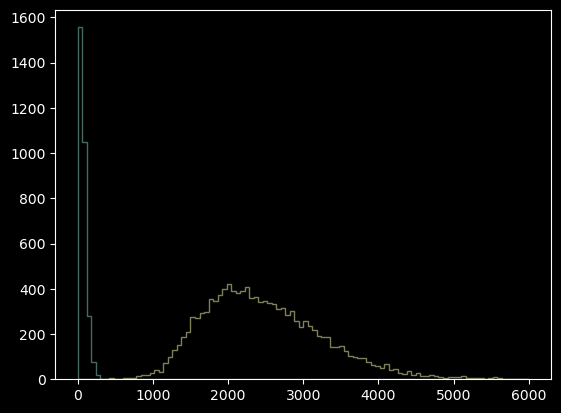

In [57]:
plt.hist(np.concatenate(day1_30k.volumes), bins=100, range=(0,6000), alpha=0.5, label='30k', histtype='step')
plt.hist(np.concatenate(day1_300k.volumes), bins=100, range=(0,6000), alpha=0.5, label='300k', histtype='step')

In [8]:
for dataset, label in zip([day1, day2, day3, day4, day5], ['day1', 'day2', 'day3', 'day4', 'day5']):
    export={'outlines':dataset.outlines, 'cc_stages':dataset.cc_stages, 'volumes':dataset.volumes}
    np.save('RAM_dump/6well suspension/'+label+'_data.npy', export)

In [4]:
for dataset, label in zip(tqdm([day1, day2, day3, day4, day5]), ['day1', 'day2', 'day3', 'day4', 'day5']):
    from_file=np.load('RAM_dump/6well suspension/'+label+'_data.npy', allow_pickle=True).item()
    dataset.outlines=from_file['outlines']
    dataset.cc_stages=from_file['cc_stages']
    dataset.volumes=from_file['volumes']
    if not hasattr(dataset.frames[0].cells[0], 'centroid'):
        for frame in dataset.frames:
            frame.get_centroids()

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
ME_0715=SuspendedDataset(r'Y:\my_data\W1\20240715 FUCCI halo ME 6days adhered_suspended\segmented\suspended', scale=0.1625, preprocess_FUCCI=False)

In [ ]:
ME_0715.red, ME_0715.green=ME_0715._normalize_FUCCI(*ME_0715._blur_FUCCI(5), quantile=(0.01,1), mask_zeros=True)

In [ ]:
seg_dir=r'Y:\my_data\W1\20240713 FUCCI halo SC serum suspended\segmented'
ctrl, low_serum, high_serum=[SuspendedDataset(seg_dir+f'/{folder}', scale=0.1625, mask_zeros=True, quantile=(0.01,1)) for folder in tqdm(['ctrl','low_serum','high_serum'])]

In [ ]:
path_ME=r'F:\Heather\FUCCI\suspended\04262024ME treatments\segmented'
airy_scale=0.6905357

WT=SuspendedDataset(path_ME+'/no treatment200k', scale=airy_scale, preprocess_FUCCI=True, blur_sigma=2)
ouabain=SuspendedDataset(path_ME+'/ouabain200k', scale=airy_scale, preprocess_FUCCI=True, blur_sigma=2)
phenformin=SuspendedDataset(path_ME+'/phenformin200k', scale=airy_scale, preprocess_FUCCI=True, blur_sigma=2)
pnd=SuspendedDataset(path_ME+'/pnd200k', scale=airy_scale, preprocess_FUCCI=True, blur_sigma=2)
sch777=SuspendedDataset(path_ME+'/sch777200k', scale=airy_scale, preprocess_FUCCI=True, blur_sigma=2)
xmu=SuspendedDataset(path_ME+'/xmu200k', scale=airy_scale, preprocess_FUCCI=True, blur_sigma=2)

In [ ]:
datasets=[WT, ouabain, phenformin, pnd, sch777, xmu]
labels=['WT', 'ouabain', 'phenformin', 'pnd', 'sch777', 'xmu']

In [ ]:
volume_folder=r'F:\Heather\FUCCI\suspended\04262024ME treatments\volumes'
for dataset, label in zip(datasets, labels):
    pd.to_pickle(dataset.volumes, volume_folder+f'/{label}.pkl')

In [ ]:
WT_dilution=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\sccontrol_dilplate', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
bum10um=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\10umbum', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
bum33um=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\33umbum', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
ycomp10um=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\10umycomp', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
ycomp33um=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\33umycomp', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)

In [ ]:
WT=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\sccontrol', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
rapamycin=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\Rapamycin', scale=0.3452677, preprocess_FUCCI=True, blur_sigma=2)
sch77=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\sch77', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)
low_serum=SuspendedDataset(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\segmented\2percfbs', scale=0.6905357, preprocess_FUCCI=True, blur_sigma=2)

In [ ]:
WT=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\Notreatment\dish1', scale=0.6905357, blur_sigma=2)
bum1=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\bum\dish1', scale=0.6905357, blur_sigma=2)
bum2=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\bum\dish2', scale=0.6905357, blur_sigma=2)
PND1=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\PND\dish1', scale=0.6905357, blur_sigma=2)
PND2=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\PND\dish2', scale=0.6905357, blur_sigma=2)
rapamycin1=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\rapamycin\dish1', scale=0.6905357, blur_sigma=2)
rapamycin2=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\rapamycin\dish2', scale=0.6905357, blur_sigma=2)
sch771=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\sch77\dish1', scale=0.6905357, blur_sigma=2)
sch772=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\sch77\dish2', scale=0.6905357, blur_sigma=2)
ycomp1=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\ycomp\dish1', scale=0.6905357, blur_sigma=2)
ycomp2=SuspendedDataset(r'F:\Heather\FUCCI\suspended\20240419\segmented\ycomp\dish2', scale=0.6905357, blur_sigma=2)

In [ ]:
#ME2_0415=SuspendedDataset(r'F:\my_data\Segmentation\20240415 halo FUCCI col_glass ME adhered_suspended\segmented\suspension2/')
ME1_0415=SuspendedDataset(r'F:\my_data\Segmentation\20240415 halo FUCCI col_glass ME adhered_suspended\segmented\suspension1/')

## Example cells

In [5]:
def crop_image(img, x, y, ROI_size):
    dims=img.shape
    half_ROI=int(ROI_size/2)
    if x-half_ROI<0 or x+half_ROI>dims[1] or y-half_ROI<0 or y+half_ROI>dims[0]:
        print(x-half_ROI, x+half_ROI, y-half_ROI, y+half_ROI)
        raise ValueError('ROI out of bounds')

    if ROI_size%2!=0:
        xlims=(x-half_ROI,x+half_ROI+1)
        ylims=(y-half_ROI,y+half_ROI+1)
    else:
        xlims=(x-half_ROI,x+half_ROI)
        ylims=(y-half_ROI,y+half_ROI)
    
    cropped=img[ylims[0]:ylims[1],xlims[0]:xlims[1]]
    return cropped

In [27]:
dataset=day5
label='day5'
original_indices = np.concatenate([np.column_stack((np.full(len(arr), i), np.arange(len(arr))))
                                   for i, arr in enumerate(dataset.cc_stages)])

circ_threshold=0.85
n_rows=20
n_cols=20

random_cells=[]
np.random.seed(0)

cc_stages=np.concatenate(dataset.cc_stages)
for cycle_stage in tqdm(range(4)):
    all_outlines=[outline for outlines in dataset.outlines for outline in outlines]
    circs=np.array([polyCircularity(*np.array(outline).T) for outline in all_outlines])
    cycle_cells=np.where((cc_stages==cycle_stage)&(circs>circ_threshold))[0]
    cycle_indices=original_indices[cycle_cells]

    if len(cycle_cells)<n_rows*n_cols:
        print(f'Fewer than {n_rows*n_cols} samples in cycle stage {cycle_stage}. Sampling all {len(cycle_cells)} cells instead.')
        n_samples=len(cycle_cells)
    # randomly sample cells
    else:
        n_samples=n_rows*n_cols

    sampled_cells=cycle_indices[np.random.choice(len(cycle_cells), n_samples, replace=False)]

    cell_areas=[dataset.frames[i].cells[j].get_area() for i, j in sampled_cells]
    sampled_cells=sampled_cells[np.argsort(cell_areas)]
    if len(sampled_cells)!=n_rows*n_cols:
        # pad with zeros
        sampled_cells=np.concatenate([sampled_cells, -np.ones((n_rows*n_cols-len(sampled_cells), 2), dtype=int)])
    
    random_cells.append(sampled_cells)

random_cells=np.array(random_cells)

  0%|          | 0/4 [00:00<?, ?it/s]

Fewer than 400 samples in cycle stage 3. Sampling all 81 cells instead.


In [28]:
frame_size=150
imgs=np.array([frame.img for frame in dataset.frames])

def simple_normalize(a, low, high):
    return np.clip((a-low)/(high-low), 0, 1)

# estimate the intensity range without calling np.quantile
intensity_samples=10**5
quantiles=[]
for channel in range(3):
    flattened=imgs[...,channel].flatten()
    idxs=np.random.choice(len(flattened), intensity_samples, replace=True)
    samples=flattened[idxs]
    quantiles.append(np.percentile(samples, [1,99]))

imgs=np.array([simple_normalize(imgs[..., channel], *quantiles[channel]) for channel in tqdm(range(3))]).transpose(1,2,3,0)
pad_size=int(frame_size/2)+1
padded_imgs=np.pad(imgs, pad_width=((0,0), (pad_size,pad_size), (pad_size,pad_size), (0,0)), mode='constant', constant_values=0)

  0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
insets=[]
for i in range(4):
    cycle_imgs=[]
    for cell_index in random_cells[i]:
        if np.array_equal(cell_index, -np.ones(2, dtype=int)):
            cycle_imgs.append(np.zeros((frame_size, frame_size, 3)))
            continue
        x, y=np.flip(dataset.frames[cell_index[0]].cells[cell_index[1]].centroid).astype(int)
        img=crop_image(padded_imgs[cell_index[0]], x+pad_size, y+pad_size, ROI_size=frame_size)
        cycle_imgs.append(img)
    insets.append(cycle_imgs)

insets=np.array(insets)

# tile the images
insets=insets.reshape(4, n_rows, n_cols, frame_size, frame_size, 3)

fig_folder=f'plots/Aug2024 adhered_suspended/6well/{label}'
Path(fig_folder).mkdir(exist_ok=True, parents=True)

for i, cc_label in enumerate(tqdm(['NS', 'G1', 'S', 'G2'])):
    images = insets[i][:n_rows*n_cols]
    images = images.transpose(0, 2, 1, 3, 4).reshape(n_cols * frame_size, n_rows * frame_size, 3)

    fig=plt.figure(figsize=(20,20))
    plt.imshow(images, vmax=0.8)
    plt.axis('off')

    plt.savefig(f'{fig_folder}/{label}-{i}_{cc_label}.jpg', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close(fig)

  0%|          | 0/4 [00:00<?, ?it/s]

In [177]:
import seaborn as sns

sns.set_theme()

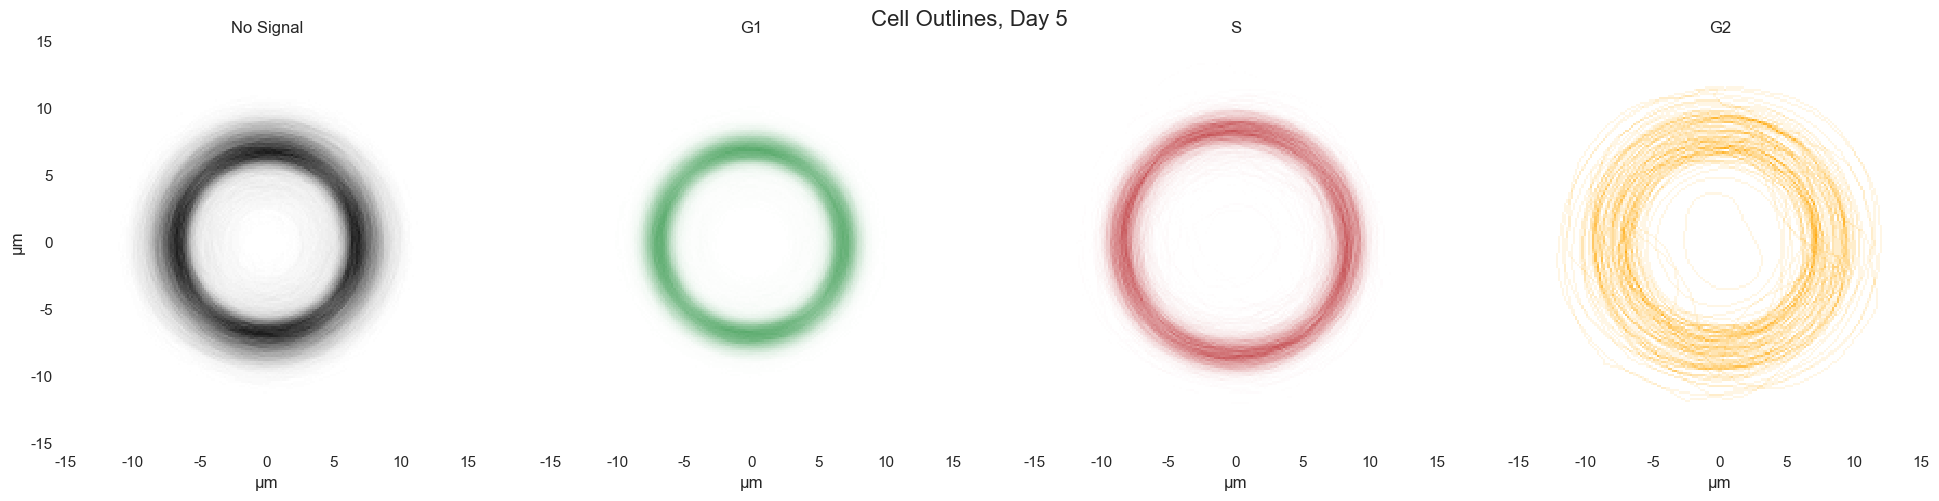

In [182]:
from matplotlib.colors import LinearSegmentedColormap

axlims=15/0.16125

cc_outlines=[]
for i in range(4):
    frame_outlines=[]
    for frame, cc_stage in zip(dataset.frames, dataset.cc_stages):
        cc_indices=np.where(cc_stage==i)[0]
        frame_outlines.extend([frame.cells[j].outline-np.flip(frame.cells[j].centroid) for j in cc_indices])
    cc_outlines.append(frame_outlines)

fig, axes=plt.subplots(1,4, figsize=(20,5), sharex=True, sharey=True)
for i, color, ax in zip(range(4), ['k','g','r','orange'], axes):
    cmap = LinearSegmentedColormap.from_list(color, ['white', color], N=100)
    outlines=np.concatenate(cc_outlines[i])
    ax.hist2d(outlines[:,0], outlines[:,1], bins=186, range=((-axlims,axlims),(-axlims,axlims)), cmap=cmap)
    ax.set_aspect('equal')
    ax.set_xlim(-axlims,axlims)
    ax.set_ylim(-axlims,axlims)

    ax.set_xticks(np.array([-15,-10,-5,0,5,10,15])/0.16125, labels=[-15,-10,-5,0,5,10,15])
    ax.set_yticks(np.array([-15,-10,-5,0,5,10,15])/0.16125, labels=[-15,-10,-5,0,5,10,15])
    ax.set_xlabel('μm')
    
    # grid
    ax.grid(True, which='both', color='w', linestyle='--', linewidth=0.5, alpha=0.5)

axes[0].set_ylabel('μm')
axes[0].set_title('No Signal')
axes[1].set_title('G1')
axes[2].set_title('S')
axes[3].set_title('G2')
fig.suptitle('Cell Outlines, Day 5', fontsize=16, y=0.95)
fig.tight_layout()

#plt.savefig(f'{fig_folder}/{label}-outlines.jpg', bbox_inches='tight', dpi=500)

7285
3017
3044
1549


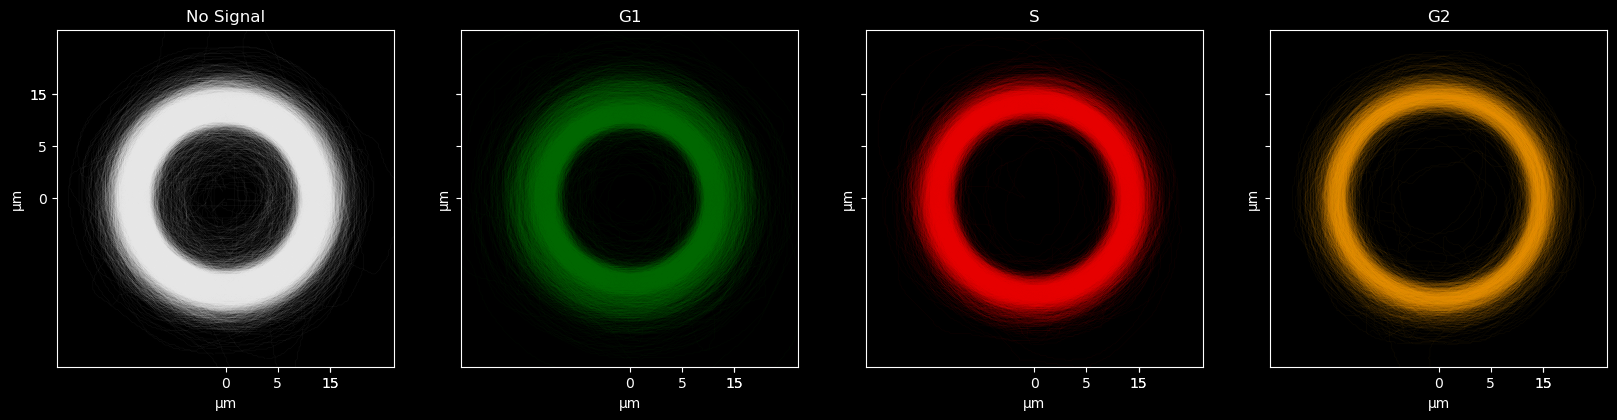

In [98]:
fig, axes=plt.subplots(1,4, figsize=(20,5), sharex=True, sharey=True)
for i, color, ax in zip(range(4), ['w','g','r','orange'], axes):
    print(len(cc_outlines[i]))
    for outline in cc_outlines[i]:
        ax.plot(*outline.T, c=color, lw=0.5, alpha=0.05)
    ax.set_aspect('equal')
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)

    ax.set_xticks(np.array([0,5,10,15])/0.16125, labels=[0,5,10,15])
    ax.set_yticks(np.array([0,5,10,15])/0.16125, labels=[0,5,10,15])
    ax.set_xlabel('μm')
    ax.set_ylabel('μm')

axes[0].set_title('No Signal')
axes[1].set_title('G1')
axes[2].set_title('S')
axes[3].set_title('G2')

plt.savefig('plots/Aug2024 adhered_suspended/6well/day1/day1-outlines.jpg', bbox_inches='tight', pad_inches=0, dpi=300)

## Check thresholds

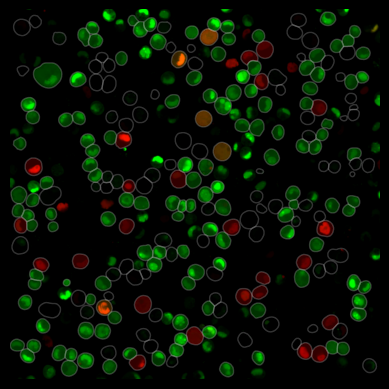

In [131]:
from monolayer_tracking import plot_tools

plot_tools.FUCCI_overlay(day4.frames[0], show_denoised=False)

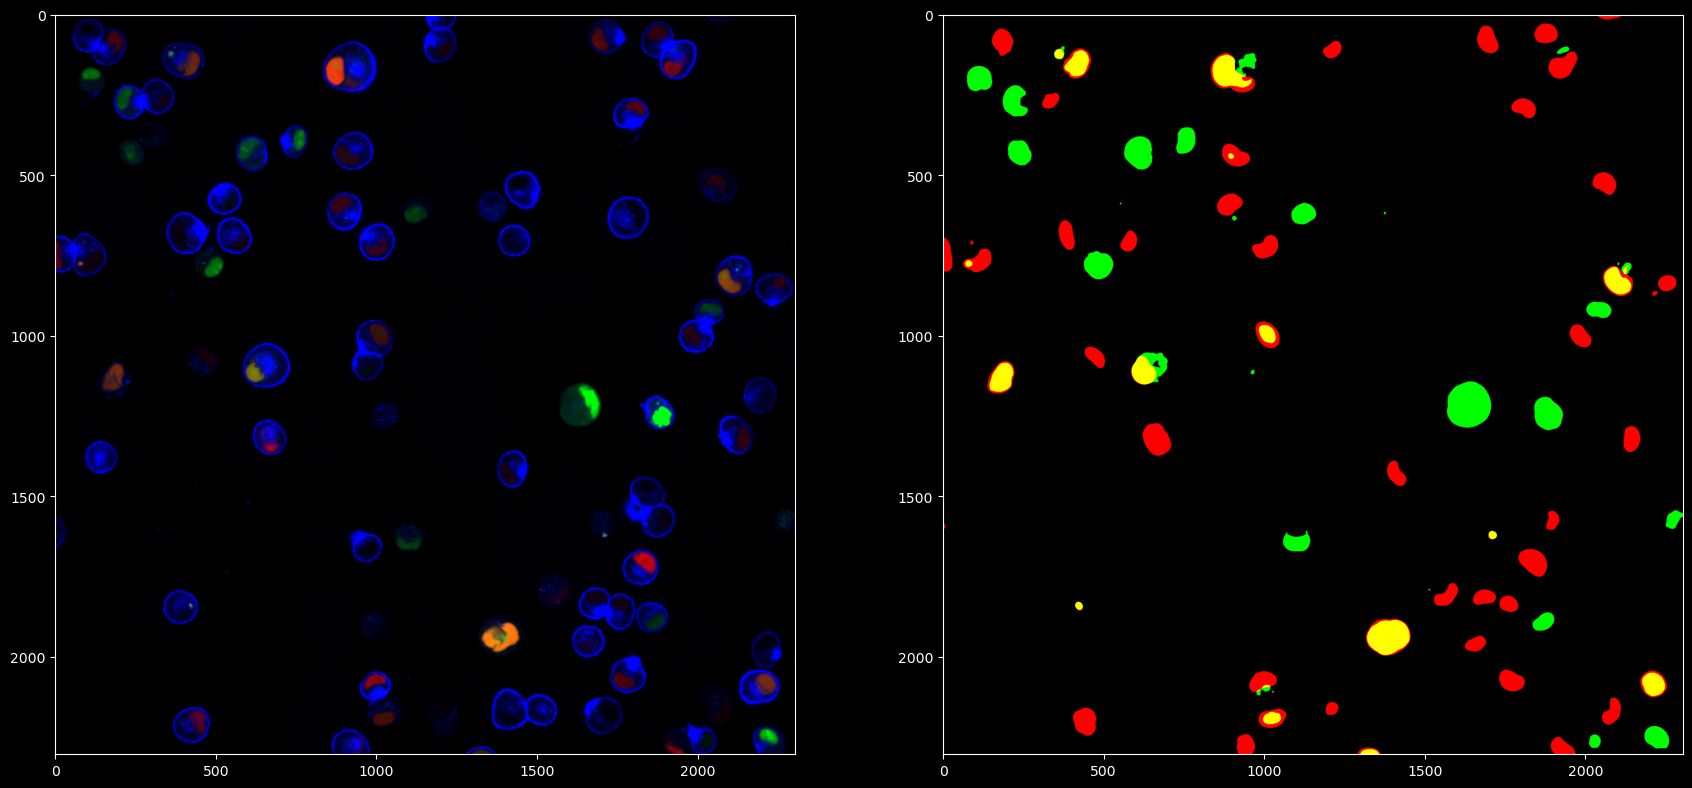

In [115]:
# visualize blurring, thresholding
n=20
to_plot=day1_300k

fig, axes=plt.subplots(1,2, figsize=(21,20))
axes[0].imshow(preprocessing.normalize(to_plot.frames[n].img))

#color_FUCCI=np.stack([to_plot.red[n], to_plot.green[n], np.zeros_like(to_plot.red[n])], axis=-1)
#axes[1].imshow(color_FUCCI)

blue_channel=np.zeros_like(to_plot.green[n]) #preprocessing.normalize(to_plot.frames[n].img[...,2])

threshold_FUCCI=np.stack([to_plot.red[n]>500, to_plot.green[n]>1800, blue_channel], axis=-1)
axes[1].imshow(threshold_FUCCI)

## Measure FUCCI

In [80]:
day3_300k.red=np.array(day3_300k.red)

In [116]:
# 20240809-14 FUCCI halo 300k 12-well
day1_300k.measure_FUCCI(red_threshold=500, green_threshold=2400)
#day2_300k.measure_FUCCI(red_threshold=2400, green_threshold=600)
#day3_300k.measure_FUCCI(red_threshold=0.05, green_threshold=1800)
#day4_300k.measure_FUCCI(red_threshold=2000, green_threshold=1800)
#day5_300k.measure_FUCCI(red_threshold=2200, green_threshold=1800)
#day6_300k.measure_FUCCI(red_threshold=2200, green_threshold=1800)

Processing frames:   0%|          | 0/225 [00:00<?, ?it/s]

[array([0, 0, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 1, 2, 2, 2, 2, 0,
        0, 0, 2, 1, 2, 1, 3, 0, 0, 1, 3, 1, 2, 0, 3, 2, 2, 2, 2, 2, 0, 2,
        2], dtype=int64),
 array([0, 0, 0, 1, 0, 2, 2, 1, 1, 1, 2, 2, 0, 1, 0, 2, 0, 2, 0, 2, 2, 1,
        2, 2, 3, 2, 2, 0, 2, 0, 0, 1, 3, 2, 2, 2, 0, 3, 1, 2, 2, 1, 2, 3,
        1, 0, 2, 3, 0, 0, 2], dtype=int64),
 array([0, 2, 2, 2, 2, 1, 3, 2, 2, 1, 2, 2, 3, 2, 0, 1, 0, 3, 3, 0, 2, 3,
        1, 0, 1, 1, 3, 2, 2, 2, 0, 0, 1, 1, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2,
        2, 0, 1, 1, 1, 1], dtype=int64),
 array([0, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1, 3, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0,
        2, 0, 3, 2, 2, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 1, 2, 0, 2, 0, 1,
        2, 2, 3, 3, 0], dtype=int64),
 array([2, 3, 3, 2, 0, 0, 0, 1, 0, 3, 3, 0, 2, 3, 2, 1, 3, 0, 0, 0, 0, 0,
        1, 2, 2, 1, 3, 2, 0, 1, 0, 2, 3, 2, 3, 0, 1, 0, 2, 0, 2, 2, 1, 0],
       dtype=int64),
 array([0, 3, 0, 0, 2, 1, 0, 2, 0, 0, 3, 2, 2, 2, 0, 2, 3, 1, 2, 0, 0, 2,
        1, 0, 2

In [117]:
for dataset in tqdm([day1_300k, day2_300k, day3_300k, day4_300k, day5_300k, day6_300k]):
    dataset.outlines=[frame.get_cell_attr('outline') for frame in dataset.frames]
    dataset.get_volumes()

  0%|          | 0/6 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
ME_0715.measure_FUCCI(red_threshold=0.4, green_threshold=0.4)

In [ ]:
ctrl.measure_FUCCI(red_threshold=0.4, green_threshold=0.3)
low_serum.measure_FUCCI(red_threshold=0.9, green_threshold=0.32)
high_serum.measure_FUCCI(red_threshold=0.99, green_threshold=0.32)
None

In [ ]:
high_serum.measure_FUCCI(red_threshold=0.08, green_threshold=0.08)
low_serum.measure_FUCCI(red_threshold=0.02, green_threshold=0.03)
ctrl.measure_FUCCI(red_threshold=0.07, green_threshold=0.05)
pass

Processing frames:   0%|          | 0/16 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/16 [00:00<?, ?it/s]

Processing frames:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
for dataset in tqdm([day1, day2, day3, day4, day5]):
    for frame, cc_stage in zip(dataset.frames, dataset.cc_stages):
        frame.write_cell_cycle(cc_stage)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
day5.get_volumes()
pd.to_pickle(day5.volumes, r'Y:\my_data\W1\20240806-10 FUCCI halo 768k coverslip suspended\volumes\day5.pkl')

Processing frames:   0%|          | 0/225 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
ycomp10um.measure_FUCCI(red_threshold=0.15, green_threshold=0.25, orange_brightness=1.5, percent_threshold=0.15)
ycomp33um.measure_FUCCI(red_threshold=0.25, green_threshold=0.25, orange_brightness=1.5, percent_threshold=0.15)

In [ ]:
ycomp10um.get_volumes()
ycomp33um.get_volumes()

In [ ]:
datasets=[WT_dilution, bum10um, bum33um, ycomp10um, ycomp33um, WT, rapamycin, sch77, low_serum]
labels=['WT_dilution', 'bum10um', 'bum33um', 'ycomp10um', 'ycomp33um', 'WT', 'rapamycin', 'sch77', 'low_serum']

In [ ]:
for dataset in tqdm(datasets, desc='datasets'):
    dataset.measure_FUCCI(red_threshold=0.1, green_threshold=0.15, orange_brightness=1.5, percent_threshold=0.15)
    dataset.get_volumes()

In [ ]:
# get FUCCI, measure volumes
for dataset in tqdm(datasets, desc='datasets'):
    dataset.measure_FUCCI(red_threshold=0.15, green_threshold=0.15, orange_brightness=1.5, percent_threshold=0.15)
    dataset.get_volumes()

In [ ]:
# get FUCCI, measure volumes
for dataset in tqdm([WT, rapamycin, sch77, low_serum]):
    dataset.measure_FUCCI(red_threshold=0.15, green_threshold=0.15, orange_brightness=1.5, percent_threshold=0.15)
    dataset.get_volumes()

In [ ]:
WT_vols=WT.volumes
bum1_vols=[np.concatenate([v1, v2]) for v1, v2 in zip(bum1.volumes, bum2.volumes)]
PND_vols=[np.concatenate([v1, v2]) for v1, v2 in zip(PND1.volumes, PND2.volumes)]
rapamycin_vols=[np.concatenate([v1, v2]) for v1, v2 in zip(rapamycin1.volumes, rapamycin2.volumes)]
sch77_vols=[np.concatenate([v1, v2]) for v1, v2 in zip(sch771.volumes, sch772.volumes)]
ycomp_vols=[np.concatenate([v1, v2]) for v1, v2 in zip(ycomp1.volumes, ycomp2.volumes)]

In [ ]:
pd.to_pickle(WT_vols, r'F:\Heather\FUCCI\suspended\20240419\volumes\WT.pkl')
pd.to_pickle(bum1_vols, r'F:\Heather\FUCCI\suspended\20240419\volumes\bum.pkl')
pd.to_pickle(PND_vols, r'F:\Heather\FUCCI\suspended\20240419\volumes\PND.pkl')
pd.to_pickle(rapamycin_vols, r'F:\Heather\FUCCI\suspended\20240419\volumes\rapamycin.pkl')
pd.to_pickle(sch77_vols, r'F:\Heather\FUCCI\suspended\20240419\volumes\sch77.pkl')
pd.to_pickle(ycomp_vols, r'F:\Heather\FUCCI\suspended\20240419\volumes\ycomp.pkl')

In [ ]:
for dataset, label in zip(datasets, labels):
    pd.to_pickle(dataset.volumes, r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\volumes'+f'/{label}.pkl')

In [ ]:
# export FUCCI labels for verification
to_plot=ycomp2
for n in tqdm(range(len(to_plot.frames)), desc='drawing frame'):
    fig=plt.figure(figsize=(10,5))
    ax_0=fig.add_subplot(121)
    to_plot.show_FUCCI(n)
    ax_0.set_title('segmented and labeled FUCCI')
    ax_1=fig.add_subplot(122)
    ax_1.imshow(np.stack([to_plot.red[n]>to_plot.red_threshold, to_plot.green[n]>to_plot.green_threshold, np.zeros_like(to_plot.red[n])], axis=-1))
    ax_1.set_title('binarized')
    plt.savefig(r'F:\Heather\FUCCI\suspended\20240419\plots\frames\ycomp/'+f'ycomp2_{n}.jpg',dpi=300, bbox_inches='tight')
    plt.close()

## volume statistics

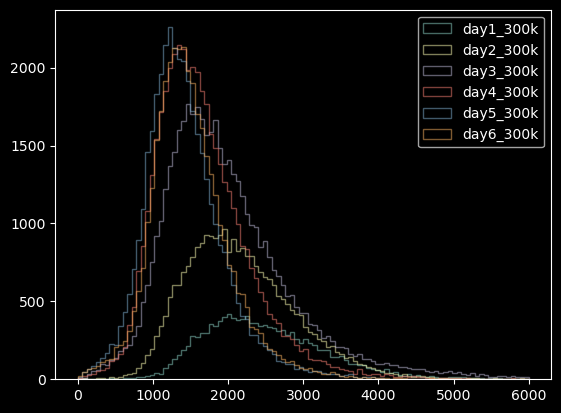

In [118]:
for dataset, label in zip([day1_300k, day2_300k, day3_300k, day4_300k, day5_300k, day6_300k], ['day1_300k', 'day2_300k', 'day3_300k', 'day4_300k', 'day5_300k', 'day6_300k']):
    plt.hist(np.concatenate(dataset.volumes), bins=100, range=(0,6000), alpha=0.5, label=label, histtype='step')
    pd.to_pickle(dataset.volumes, r'Y:\my_data\W1\20240809-14 FUCCI halo 300k 12-well\volumes/suspended/'+label+'.pkl')
plt.legend()

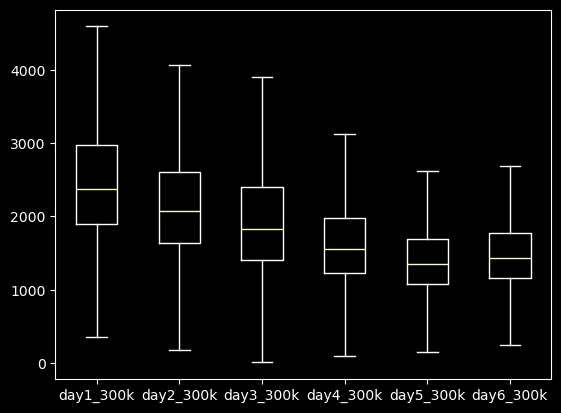

In [104]:
plt.boxplot([np.concatenate(dataset.volumes) for dataset in [day1_300k, day2_300k, day3_300k, day4_300k, day5_300k, day6_300k]], labels=['day1_300k', 'day2_300k', 'day3_300k', 'day4_300k', 'day5_300k', 'day6_300k'], showfliers=False)
plt.show()

In [32]:
vol_0412_ME=pd.read_pickle(r'RAM_dump/volumes/20240412 ME.pkl')
vol_0411_SC=pd.read_pickle(r'RAM_dump/volumes/20240411 SC.pkl')
vol_0415_ME1=pd.read_pickle(r'RAM_dump/volumes/20240415 ME_1.pkl')
vol_0415_ME2=pd.read_pickle(r'RAM_dump/volumes/20240415 ME_2.pkl')

In [225]:
vol_Heather_SC=pd.read_pickle(r'F:\Heather\FUCCI\suspended\20240410\volumes\SC.pkl')
vol_0407_SC=pd.read_pickle(r'F:\my_data\Segmentation\20240407 FUCCI suspension\volumes\SC.pkl')
vol_0413_SC=pd.read_pickle(r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\volumes\SC.pkl')
vol_0413_ME=pd.read_pickle(r'F:\my_data\Segmentation\20240413 FUCCI halo suspension\volumes\ME.pkl')

In [ ]:
ME_0715.get_volumes()

In [35]:
pd.to_pickle(ME_0715.volumes, r'Y:\my_data\W1\20240715 FUCCI halo ME 6days adhered_suspended\volumes\suspended.pkl')

In [37]:
ctrl.get_volumes()
low_serum.get_volumes()
high_serum.get_volumes()
pass

Getting outlines:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

Getting outlines:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating volumes:   0%|          | 0/4 [00:00<?, ?it/s]

In [38]:
pd.to_pickle(ctrl.volumes, r'Y:\my_data\W1\20240713 FUCCI halo SC serum suspended\volumes\ctrl.pkl')
pd.to_pickle(low_serum.volumes, r'Y:\my_data\W1\20240713 FUCCI halo SC serum suspended\volumes\low_serum.pkl')
pd.to_pickle(high_serum.volumes, r'Y:\my_data\W1\20240713 FUCCI halo SC serum suspended\volumes\high_serum.pkl')

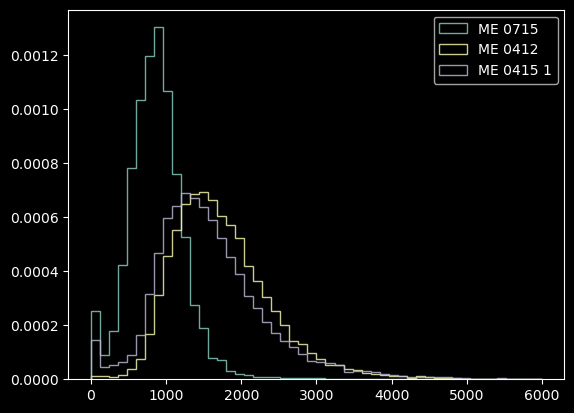

In [38]:
plt.hist(np.concatenate(ME_0715.volumes), bins=50, alpha=0.8, label='ME 0715', histtype='step', density=True, range=(0,6000))
plt.hist(np.concatenate(vol_0412_ME), bins=50, alpha=0.8, label='ME 0412', histtype='step', density=True, range=(0,6000))
plt.hist(np.concatenate(vol_0415_ME1), bins=50, alpha=0.8, label='ME 0415 1', histtype='step', density=True, range=(0,6000))

plt.legend()

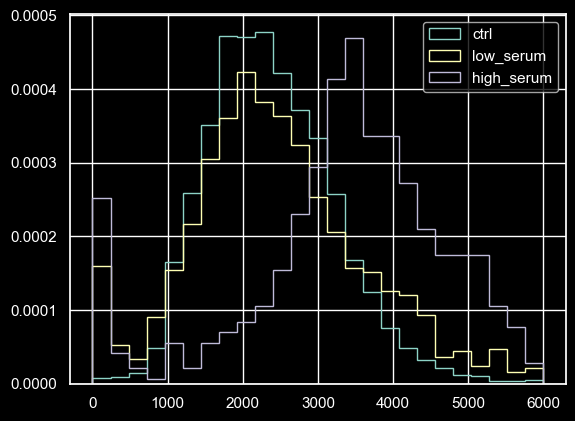

In [79]:
for dataset, label in zip([ctrl, low_serum, high_serum], ['ctrl', 'low_serum', 'high_serum']):
    plt.hist(np.concatenate(dataset.volumes), range=(0,6000), bins=25, histtype='step', density=True, label=label)

plt.legend()

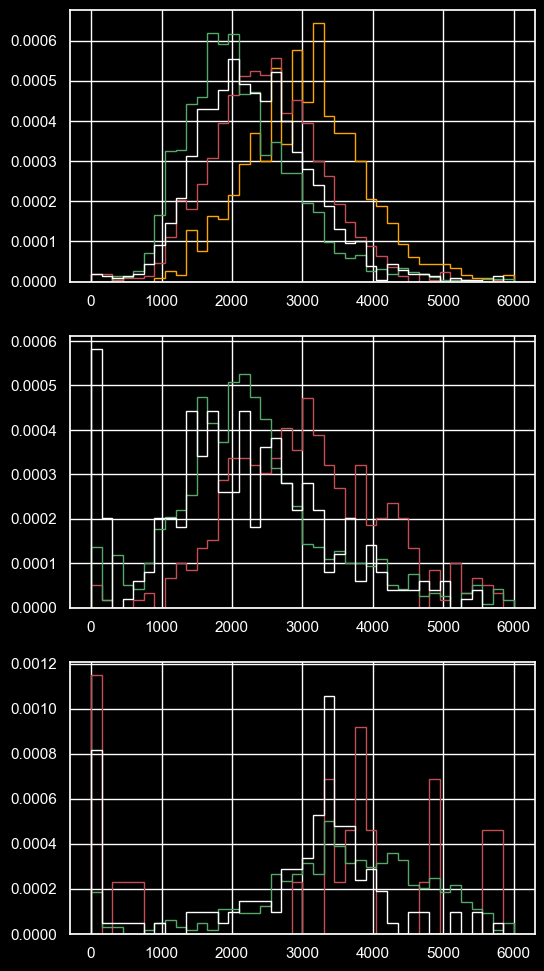

In [81]:
fig, axes=plt.subplots(3,1, figsize=(6,12))
for data, ax, label in zip([ctrl, low_serum, high_serum], axes, ['ctrl', 'low_serum', 'high_serum']):
    ax.hist(data.volumes, histtype='step', range=(0,6000), bins=40, density=True, color=['w','g','r','orange'])

### Occupancy barplot

In [94]:
# bar plots of cell cycle stage distributions
def cc_occupancy(vol):
    return [len(v)/len(np.concatenate(vol)) for v in vol]

def multi_barplot(vols, labels, ax=None, hatching=False, xticks=['NS', 'G1', 'S', 'G2'], **kwargs):
    if not ax:
        ax=plt.gca()
        
    num_groups=len(vols)
    width=1/(num_groups+1)

    x=np.arange(len(xticks))

    # if kwargs is not empty, use it to set bar properties
    bar_kwargs=[{} for i in range(num_groups)]
    for key, values in kwargs.items():
        for i, value in enumerate(values):
            bar_kwargs[i][key]=value

    for i, vol in enumerate(vols):
        if hatching:
            if labels[i].startswith('SC'):
                hatching='ooo'
            else:
                hatching='///'
        else:
            hatching=None

        ax.bar(x+i*width, cc_occupancy(vol), width, align='edge', edgecolor='k', hatch=hatching, label=labels[i], **bar_kwargs[i])
    
    plt.xticks(x+width*num_groups/2, xticks) # centered labels
    plt.legend()

Text(0.5, 1.0, 'Cell cycle stage distributions in suspended cells, 20240419')

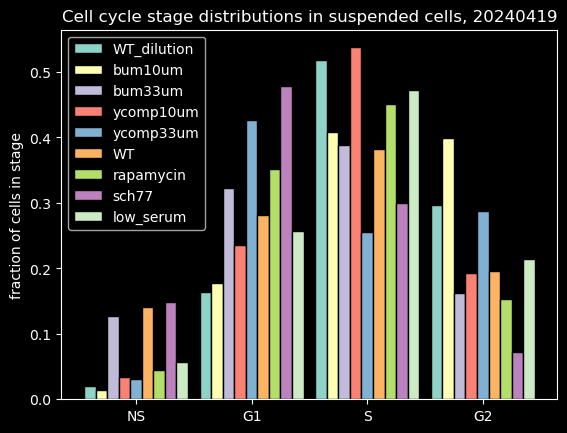

In [118]:
multi_barplot([d.volumes for d in datasets], labels)
plt.ylabel('fraction of cells in stage')
plt.title('Cell cycle stage distributions in suspended cells, 20240419')
#plt.savefig(r'F:\Heather\FUCCI\suspended\04262024ME treatments\plots\cc_occupancy.jpg', bbox_inches='tight', dpi=300)

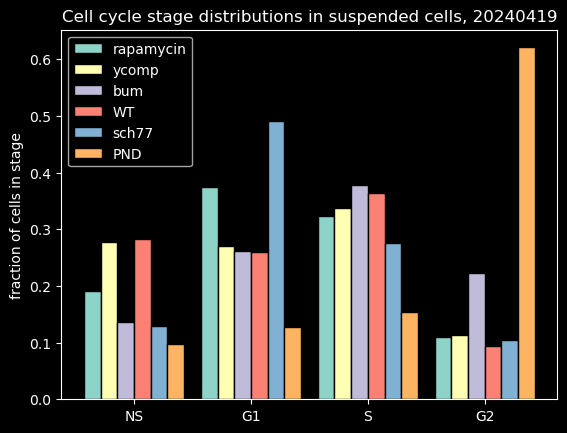

In [ ]:
multi_barplot([rapamycin_vols, ycomp_vols, bum1_vols, WT_vols, sch77_vols, PND_vols], ['rapamycin', 'ycomp', 'bum', 'WT', 'sch77', 'PND'])
plt.ylabel('fraction of cells in stage')
plt.title('Cell cycle stage distributions in suspended cells, 20240419')
plt.savefig(r'F:\Heather\FUCCI\suspended\20240419\cc_occupancy.jpg', bbox_inches='tight', dpi=300)

[{}, {}, {}]
[{'color': 'C0'}, {'color': 'C5'}, {'color': 'C6'}]
[{}, {}, {}]
[{'color': 'C0'}, {'color': 'C2'}, {'color': 'C7'}]


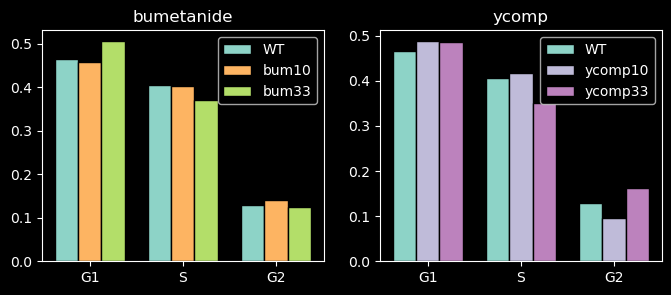

In [246]:
fig=plt.figure(figsize=(8,3))
ax=fig.add_subplot(121)
multi_barplot([WT.volumes[1:], bum10um.volumes[1:], bum33um.volumes[1:]], ['WT', 'bum10', 'bum33'], ax=ax, xticks=['G1', 'S', 'G2'], color=['C0', 'C5', 'C6'])
ax.set_title('bumetanide')

ax=fig.add_subplot(122)
multi_barplot([WT.volumes[1:], ycomp10um.volumes[1:], ycomp33um.volumes[1:]], ['WT', 'ycomp10', 'ycomp33'], ax=ax, xticks=['G1', 'S', 'G2'], color=['C0', 'C2', 'C7'])
ax.set_title('ycomp')

plt.savefig(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\plots\dilution_cc_occupancy.jpg', bbox_inches='tight', dpi=300)

[{}, {}, {}, {}]
[{}, {}, {}, {}]


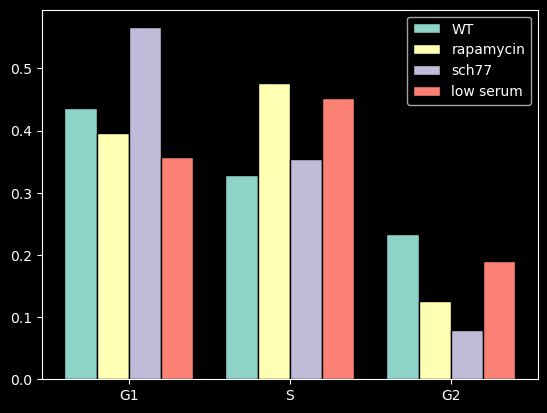

In [215]:
multi_barplot([WT.volumes[1:], rapamycin.volumes[1:], sch77.volumes[1:], low_serum.volumes[1:]], ['WT', 'rapamycin', 'sch77', 'low serum'], xticks=['G1', 'S', 'G2'])
plt.savefig(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\plots\cc_occupancy.jpg', bbox_inches='tight', dpi=300)

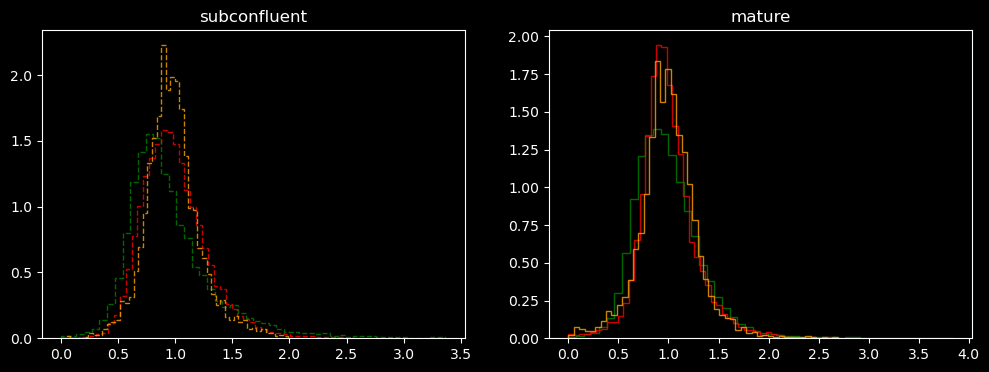

In [245]:
colors=['g','r','orange']
all_ME=[np.concatenate([v1,v2]) for v1, v2 in zip(vol_0412_ME, vol_0415_ME2)]
all_SC=[np.concatenate([v1,v2]) for v1, v2 in zip(vol_0411_SC, vol_0407_SC)]

fig, axes=plt.subplots(1,2,figsize=(12,4))

axes[0].set_title('subconfluent')
axes[1].set_title('mature')

for i, data in enumerate(all_SC[1:]):
    axes[0].hist(data/np.mean(data), bins=50, range=(0,6000/np.mean(data)), density=True, linestyle='--', alpha=0.8, histtype='step', color=colors[i])
for i, data in enumerate(all_ME[1:]):
    axes[1].hist(data/np.mean(data), bins=50, range=(0,6000/np.mean(data)), density=True, alpha=0.8, histtype='step', color=colors[i])

Text(0.5, 1.0, 'suspended cell volumes at SC and ME')

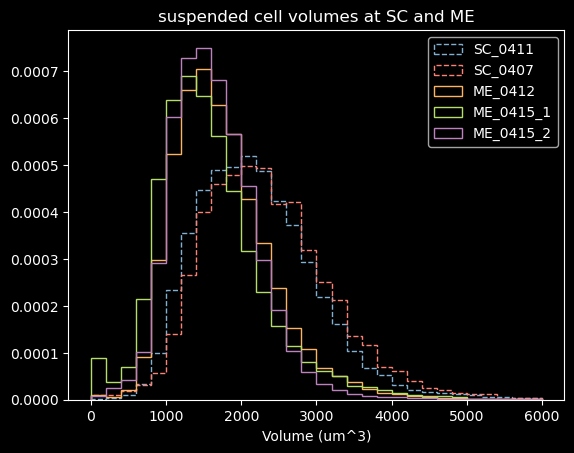

In [271]:
plt.hist(np.concatenate(vol_0411_SC[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='SC_0411', color='C4')
plt.hist(np.concatenate(vol_0407_SC[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='SC_0407', color='C3')
#plt.hist(np.concatenate(vol_0413_SC[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='SC_0413', color='C2')
#plt.hist(np.concatenate(vol_Heather_SC[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='Heather_SC', color='C2')
plt.hist(np.concatenate(vol_0412_ME[1:]), bins=30, range=(0,6000), density=True, histtype='step', label='ME_0412', color='C5')
plt.hist(np.concatenate(vol_0415_ME1[1:]), bins=30, range=(0,6000), density=True, histtype='step', label='ME_0415_1', color='C6')
plt.hist(np.concatenate(vol_0415_ME2[1:]), bins=30, range=(0,6000), density=True, histtype='step', label='ME_0415_2', color='C7')
#plt.hist(np.concatenate(vol_0413_ME[1:]), bins=30, range=(0,6000), density=True, histtype='step', label='ME_0413', color='C8')

plt.legend()

plt.xlabel('Volume (um^3)')
plt.title('suspended cell volumes at SC and ME')

#plt.savefig('plots/suspended_volumes/volume_hist.jpg', dpi=300)

Text(0.5, 0, 'volume/<volume>')

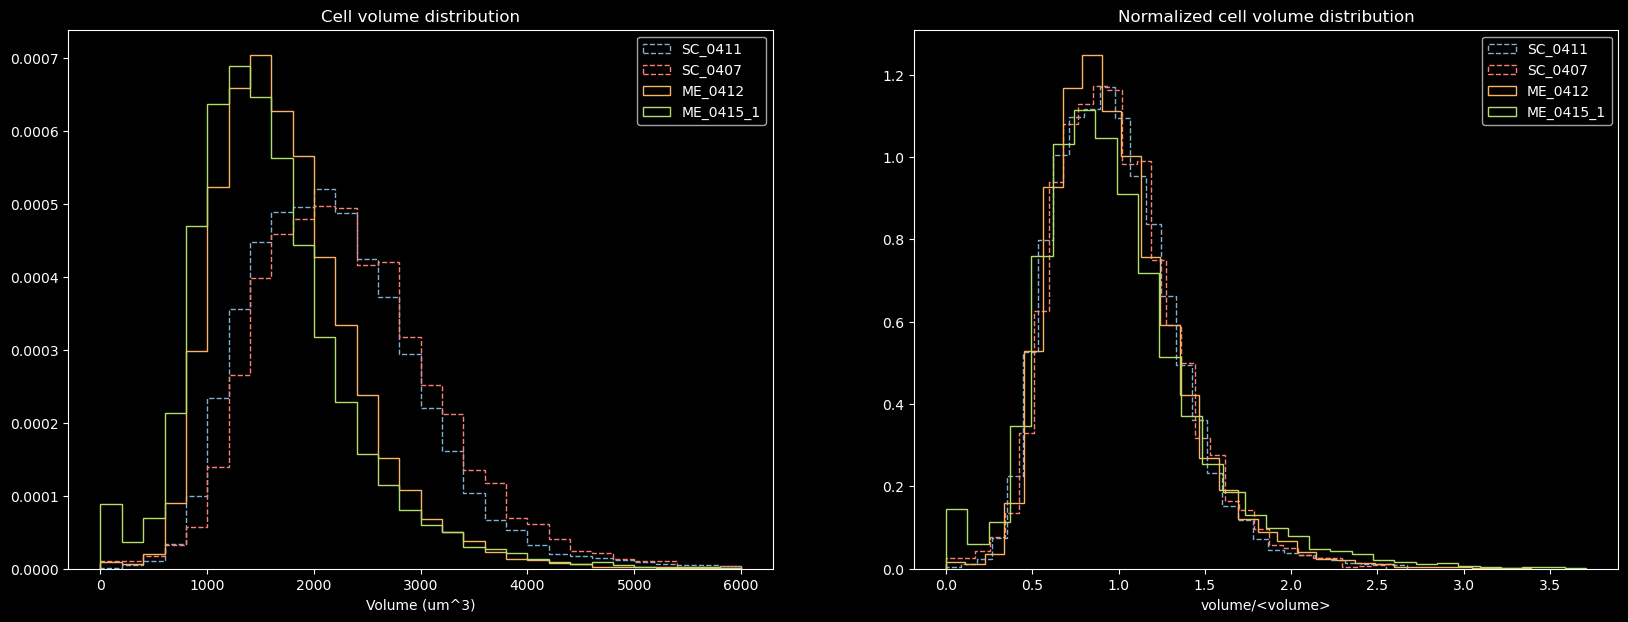

In [35]:
def volume_hist(volumes, ax, normalize=False, label=None, bins=30, range=(0,6000), density=True, histtype='step', **kwargs):
    volumes=np.concatenate(volumes)
    if normalize:
        range=(0, range[1]/np.mean(volumes))
        volumes/=np.mean(volumes)

    if label is not None and label.startswith('SC'):
        linestyle='--'
    else:
        linestyle='-'

    ax.hist(volumes, bins=bins, range=range, density=density, label=label, linestyle=linestyle, histtype=histtype, **kwargs)

fig, axes=plt.subplots(1,2, figsize=(20,7))

volume_hist(vol_0411_SC[1:], axes[0], label='SC_0411', color='C4')
volume_hist(vol_0407_SC[1:], axes[0], label='SC_0407', color='C3')
volume_hist(vol_0412_ME[1:], axes[0], label='ME_0412', color='C5')
volume_hist(vol_0415_ME1[1:], axes[0], label='ME_0415_1', color='C6')

volume_hist(vol_0411_SC[1:], axes[1], label='SC_0411', color='C4', normalize=True)
volume_hist(vol_0407_SC[1:], axes[1], label='SC_0407', color='C3', normalize=True)
volume_hist(vol_0412_ME[1:], axes[1], label='ME_0412', color='C5', normalize=True)
volume_hist(vol_0415_ME1[1:], axes[1], label='ME_0415_1', color='C6', normalize=True)

axes[0].legend()
axes[1].legend()

axes[0].set_title('Cell volume distribution')
axes[1].set_title('Normalized cell volume distribution')

axes[0].set_xlabel('Volume (um^3)')
axes[1].set_xlabel('volume/<volume>')

In [ ]:
fig, axes=plt.subplots(1,3, figsize=(20,6))

for vol,label in zip([vol_0411_SC, vol_0413_SC,vol_0412_ME, vol_0415_ME2, vol_0415_ME1], ['SC_0411', 'SC_0413', 'ME_0412', 'ME_0415_2', 'ME_0415_1']):
    if label.startswith('SC'):
        linestyle='--'
    else:
        linestyle='-'
    for ax, v in zip(axes, vol[1:]):
        ax.hist(v, bins=30, range=(0,6000), density=True, histtype='step', linestyle=linestyle, label=label)

axes[2].legend()
axes[0].set_title('G1')
axes[1].set_title('S')
axes[2].set_title('G2')

In [168]:
[len(v) for v in low_serum.volumes]

[1004, 2130, 2700, 1134]

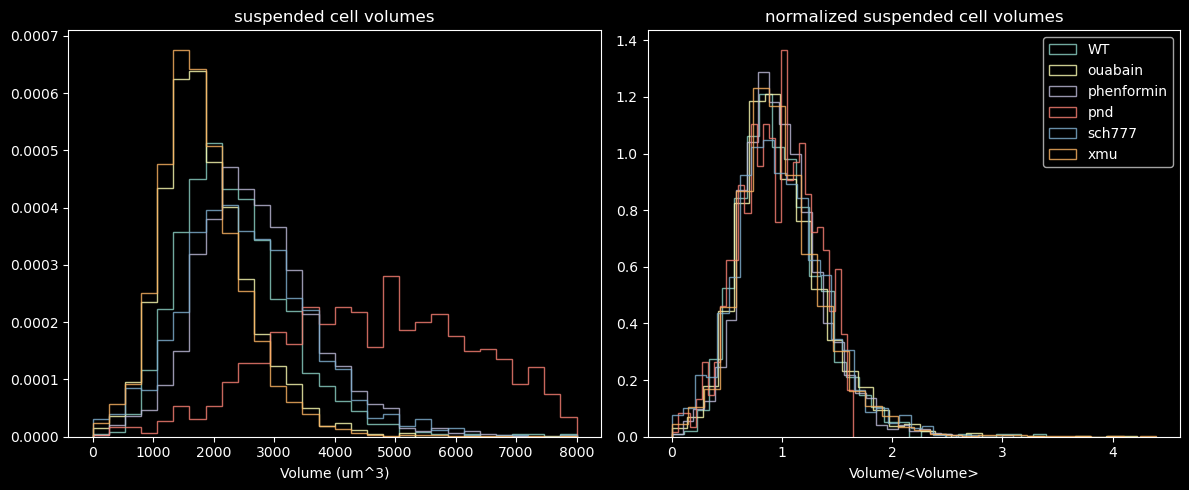

In [40]:
fig, axes=plt.subplots(1,2, figsize=(12,5))

for dataset, label in zip([d.volumes for d in datasets], labels):
    axes[0].hist(np.concatenate(dataset[1:]), range=(0,8000), bins=30, density=True, histtype='step', alpha=0.8, label=label)
    axes[1].hist(np.concatenate(dataset[1:])/np.mean(np.concatenate(dataset[1:])), range=(0,8000/np.mean(np.concatenate(dataset[1:]))), bins=30, density=True, histtype='step', alpha=0.8, label=label)

axes[1].legend()
axes[0].set_xlabel('Volume (um^3)')
axes[1].set_xlabel('Volume/<Volume>')
axes[0].set_title('suspended cell volumes')
axes[1].set_title('normalized suspended cell volumes')

fig.tight_layout()
plt.savefig(r'F:\Heather\FUCCI\suspended\04262024ME treatments\plots\volume_hist.jpg', bbox_inches='tight', dpi=300)

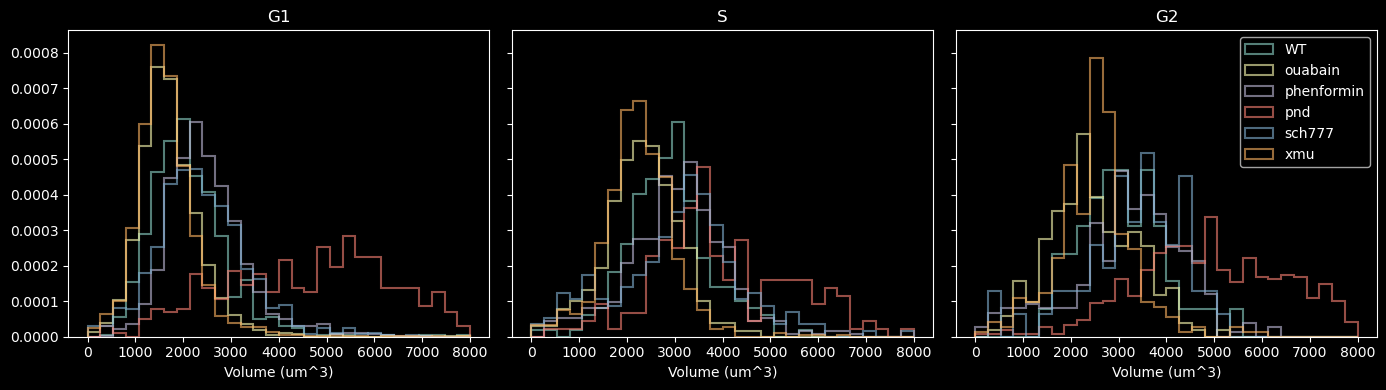

In [41]:
fig, axes=plt.subplots(1,3, figsize=(14,4), sharex=True, sharey=True)
for dataset, label in zip([d.volumes for d in datasets], labels):
    for ax, data in zip(axes, dataset[1:]):
        ax.hist(data, range=(0,8000), bins=30, density=True, histtype='step', alpha=0.6, linewidth=1.5, label=label)

for ax, title in zip(axes, ['G1','S','G2']):
    ax.set_title(title)
    ax.set_xlabel('Volume (um^3)')
    
axes[2].legend()
fig.tight_layout()

plt.savefig(r'F:\Heather\FUCCI\suspended\04262024ME treatments\plots\cc_volume_hist.jpg', bbox_inches='tight', dpi=300)

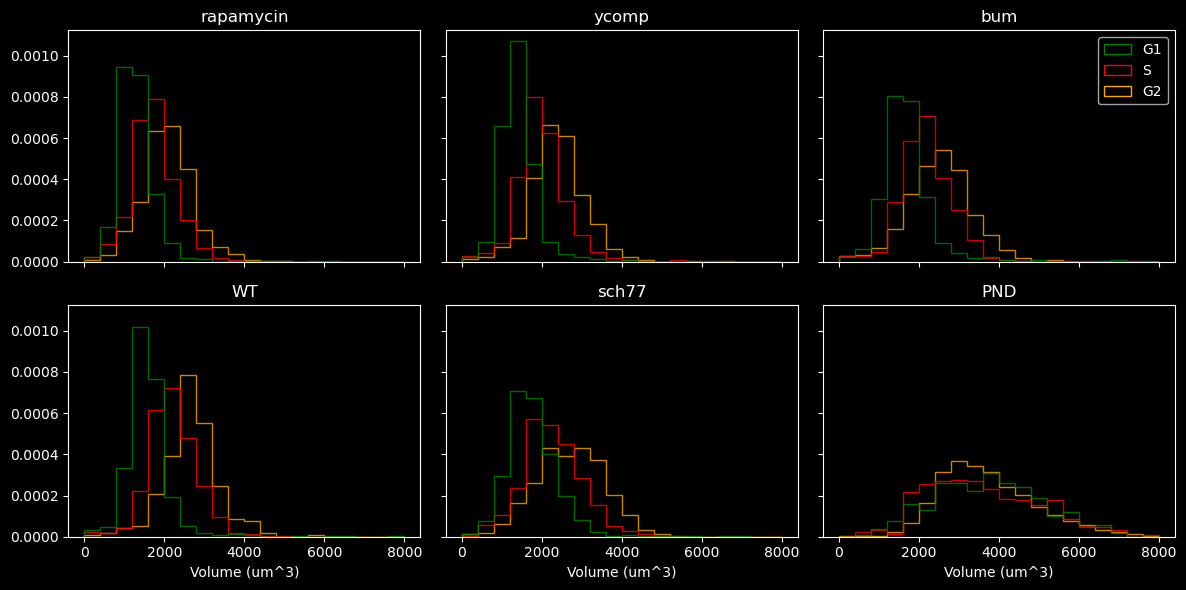

In [209]:
fig, axes=plt.subplots(2,3, figsize=(12,6), sharex=True, sharey=True)
for dataset, label, ax in zip([rapamycin_vols, ycomp_vols, bum1_vols, WT_vols, sch77_vols, PND_vols], ['rapamycin', 'ycomp', 'bum', 'WT', 'sch77', 'PND'], axes.flatten()):
    ax.hist(dataset[1:], range=(0,8000), bins=20, density=True, histtype='step', alpha=0.8, color=['g','r','orange'])
    ax.set_title(label)

for ax in axes[1]:
    ax.set_xlabel('Volume (um^3)')

axes[0,2].bar(0,0, color='k', ec='g', label='G1')
axes[0,2].bar(0,0, color='k', ec='r', label='S')
axes[0,2].bar(0,0, color='k', ec='orange', label='G2')
axes[0,2].legend()

fig.tight_layout()
plt.savefig(r'F:\Heather\FUCCI\suspended\20240419\plots\treatment_volume_hist.jpg', bbox_inches='tight', dpi=300)

In [26]:
def volume_boxplot(vols, labels, ax=None):
    if not ax:
        ax=plt.gca()
    num_groups=len(vols)
    colors=['k','g','r','orange']
    
    for i, vol in enumerate(vols):
        n_samples=[len(v) for v in vol]
        box_labels=[f"{labels[i]}\n n={n}" for n in n_samples]
        bp=ax.boxplot(vol, positions=np.arange(i*5, i*5+4), patch_artist=True, showfliers=False, labels=box_labels)

        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            
    plt.xticks(rotation=45)
    ax.set_ylabel('volume (um^3)')

In [27]:
print([np.median(v[1]) for v in [d.volumes for d in datasets]])

[1989.0182476102987, 1653.2805928793134, 2392.1485511085, 5008.9596865537715, 2315.420154608444, 1587.2701575873252]


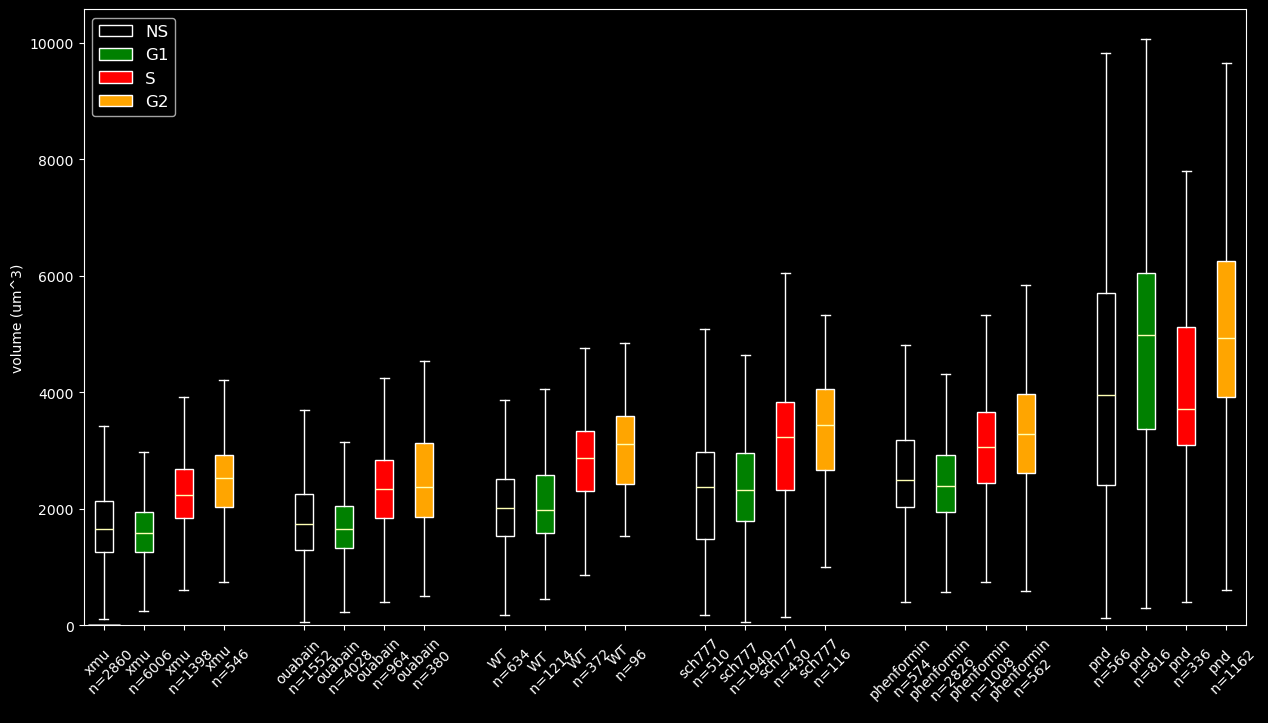

In [42]:
plt.figure(figsize=(15,8))
volume_boxplot([d.volumes for d in [xmu, ouabain, WT, sch777, phenformin, pnd]], ['xmu','ouabain','WT','sch777','phenformin','pnd'])
# fake legend with NS, G1, S, G2
plt.bar(0,0, color='k', ec='white', label='NS')
plt.bar(0,0, color='g', ec='white', label='G1')
plt.bar(0,0, color='r', ec='white', label='S')
plt.bar(0,0, color='orange', ec='white', label='G2')
plt.legend(fontsize=12)

plt.savefig(r'F:\Heather\FUCCI\suspended\04262024ME treatments\plots\volume_boxplot.jpg', bbox_inches='tight', dpi=300)

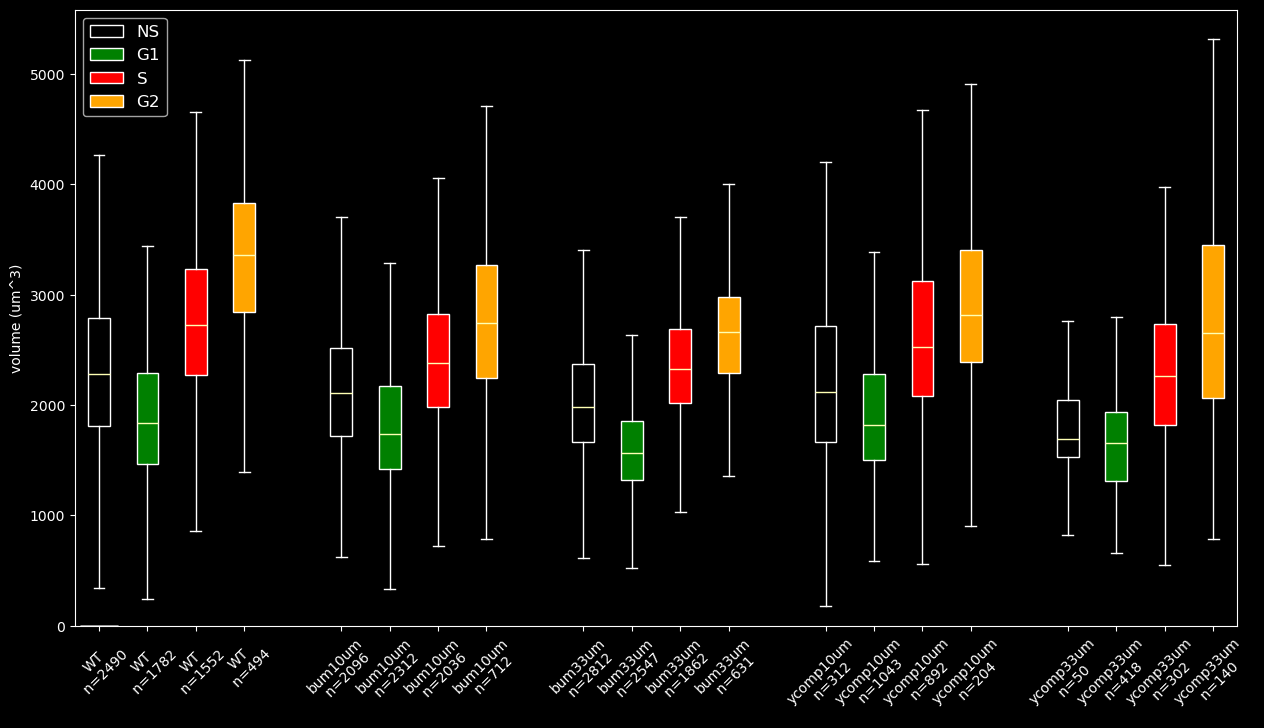

In [249]:
plt.figure(figsize=(15,8))
volume_boxplot([WT.volumes, bum10um.volumes, bum33um.volumes, ycomp10um.volumes, ycomp33um.volumes], ['WT', 'bum10um', 'bum33um', 'ycomp10um', 'ycomp33um'])
# fake legend with NS, G1, S, G2
plt.bar(0,0, color='k', ec='white', label='NS')
plt.bar(0,0, color='g', ec='white', label='G1')
plt.bar(0,0, color='r', ec='white', label='S')
plt.bar(0,0, color='orange', ec='white', label='G2')
plt.legend(fontsize=12)

plt.savefig(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\plots\dilution_volume_boxplot.jpg', bbox_inches='tight', dpi=300)

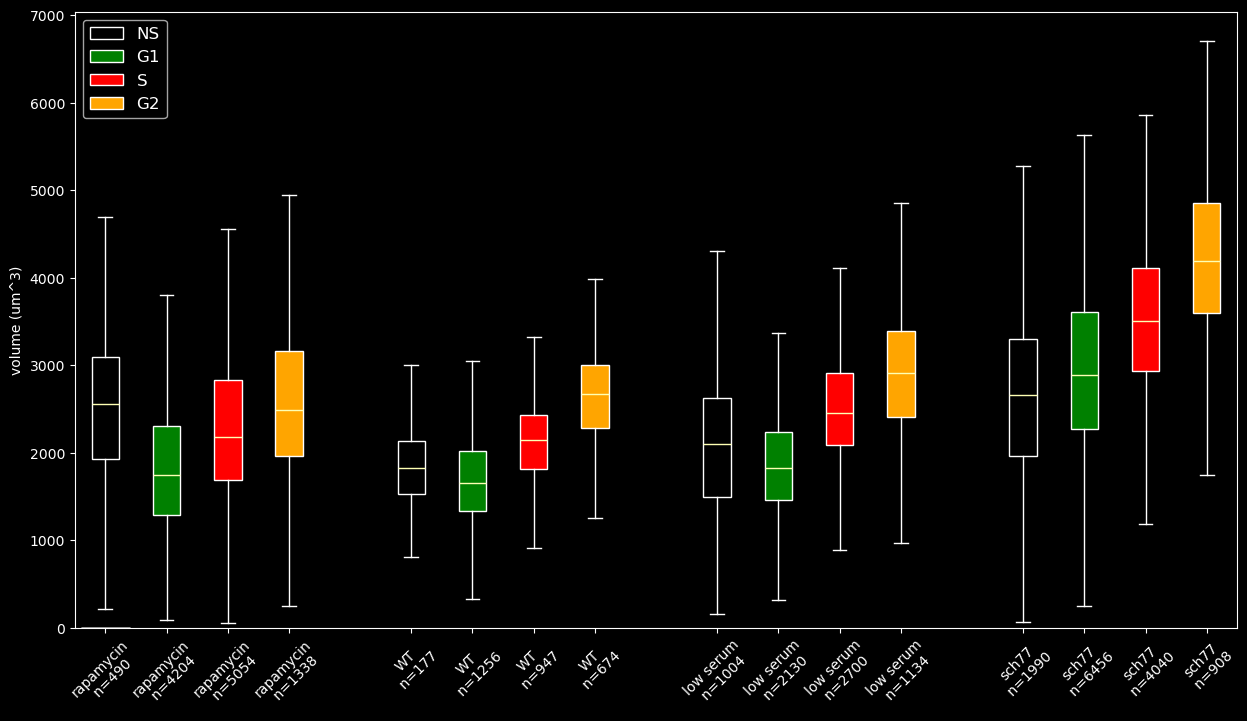

In [214]:
plt.figure(figsize=(15,8))
volume_boxplot([rapamycin.volumes, WT.volumes, low_serum.volumes, sch77.volumes], ['rapamycin', 'WT', 'low serum', 'sch77'])
# fake legend with NS, G1, S, G2
plt.bar(0,0, color='k', ec='white', label='NS')
plt.bar(0,0, color='g', ec='white', label='G1')
plt.bar(0,0, color='r', ec='white', label='S')
plt.bar(0,0, color='orange', ec='white', label='G2')
plt.legend(fontsize=12)

plt.savefig(r'F:\Heather\FUCCI\suspended\04252024 SC treatments and ycomp bum dilutions\plots\volume_boxplot.jpg', bbox_inches='tight', dpi=300)

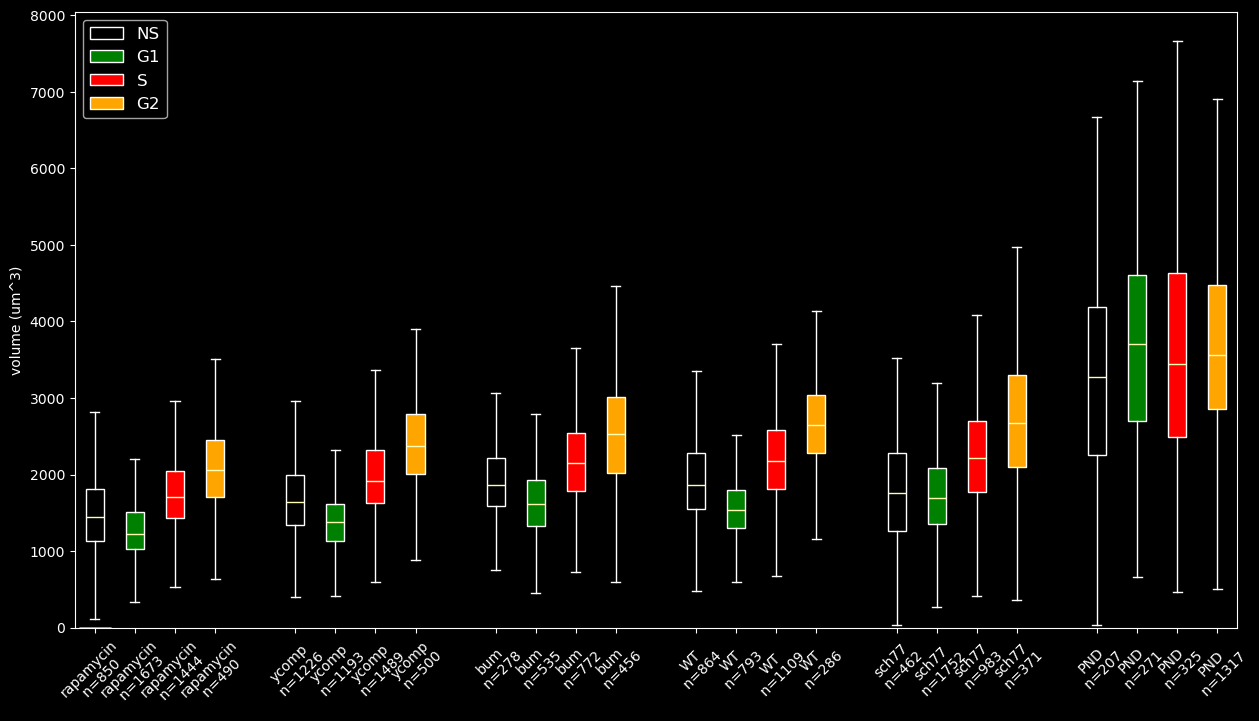

In [176]:
plt.figure(figsize=(15,8))
volume_boxplot([rapamycin_vols, ycomp_vols, bum1_vols, WT_vols, sch77_vols, PND_vols], ['rapamycin', 'ycomp', 'bum', 'WT', 'sch77', 'PND'])
# fake legend with NS, G1, S, G2
plt.bar(0,0, color='k', ec='white', label='NS')
plt.bar(0,0, color='g', ec='white', label='G1')
plt.bar(0,0, color='r', ec='white', label='S')
plt.bar(0,0, color='orange', ec='white', label='G2')
plt.legend(fontsize=12)

plt.savefig(r'F:\Heather\FUCCI\suspended\20240419\plots\volume_boxplot.jpg', bbox_inches='tight', dpi=300)

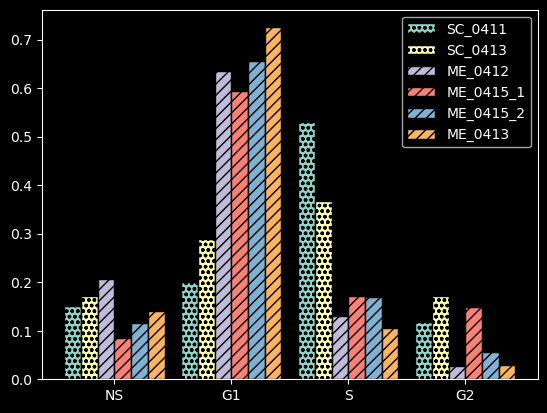

In [23]:
multi_barplot([vol_0411_SC, vol_0413_SC, vol_0412_ME, vol_0415_ME1, vol_0415_ME2, vol_0413_ME], ['SC_0411','SC_0413','ME_0412','ME_0415_1', 'ME_0415_2', 'ME_0413'], plt.gca())

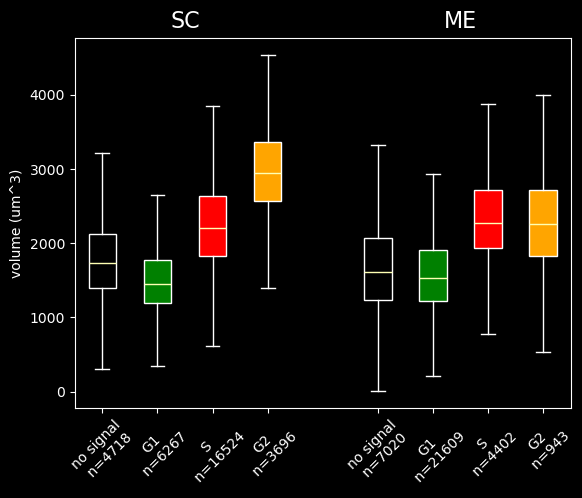

In [132]:
volumes=SC_0411.volumes+ME_0412.volumes
names=['no signal', 'G1', 'S', 'G2']*2
n_samples=[len(v) for v in volumes]

labels=[f"{name}\n n={n}" for name, n in zip(names, n_samples)]
colors=['k','g','r','orange']*2
bp=plt.boxplot(volumes, positions=[1,2,3,4,6,7,8,9],patch_artist=True, showfliers=False, labels=labels)
plt.xticks(rotation=45)
plt.ylabel('volume (um^3)')

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# label first group as subconfluent, second group as mature
plt.text(2.5, 4900, 'SC', fontsize=16, ha='center')
plt.text(7.5, 4900, 'ME', fontsize=16, ha='center')

fig.tight_layout()
#plt.savefig('plots/suspended_volumes/20240412 suspended volumes.jpg', bbox_inches='tight',dpi=300)

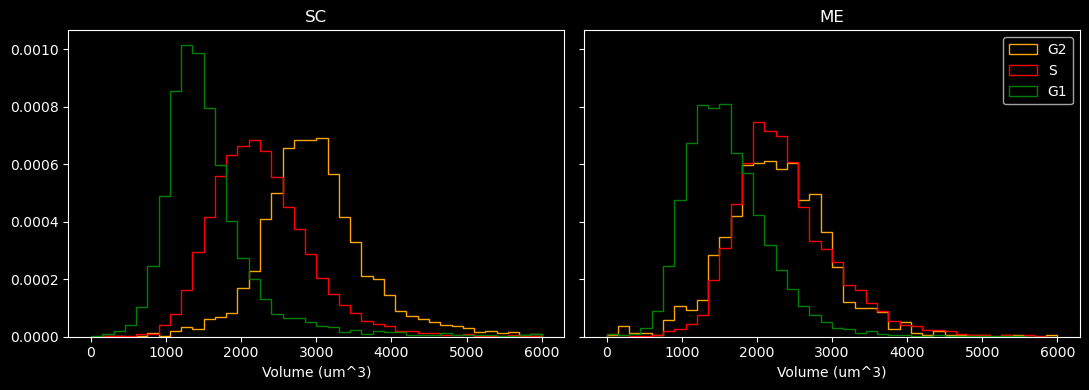

In [123]:
fig, axes=plt.subplots(1,2, figsize=(11,4), sharey=True)
axes[0].hist(SC_0411.volumes[1:], bins=40, range=(0,6000), density=True, histtype='step', label=['G1', 'S', 'G2'], color=['g','r','orange'])
axes[1].hist(ME_0412.volumes[1:], bins=40, range=(0,6000), density=True, histtype='step', label=['G1', 'S', 'G2'], color=['g','r','orange'])

axes[1].legend()

axes[0].set_title('SC')
axes[1].set_title('ME')

axes[0].set_xlabel('Volume (um^3)')
axes[1].set_xlabel('Volume (um^3)')
fig.tight_layout()

plt.savefig('plots/suspended_volumes/FUCCI_volume_hist.jpg', dpi=300)

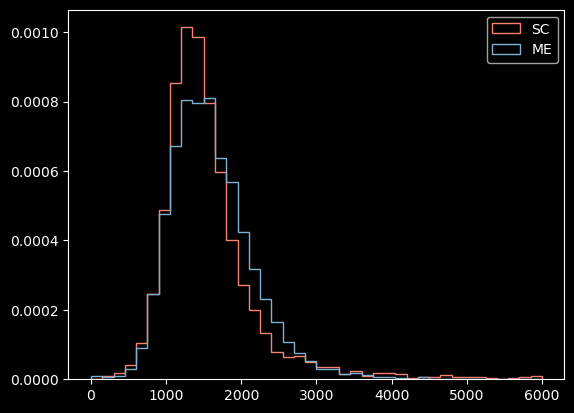

In [90]:
plt.hist(SC_0411.volumes[1], bins=40, range=(0,6000), density=True, histtype='step', label='SC', color='C3')
plt.hist(ME_0412.volumes[1], bins=40, range=(0,6000), density=True, histtype='step', label='ME', color='C4')
plt.legend()

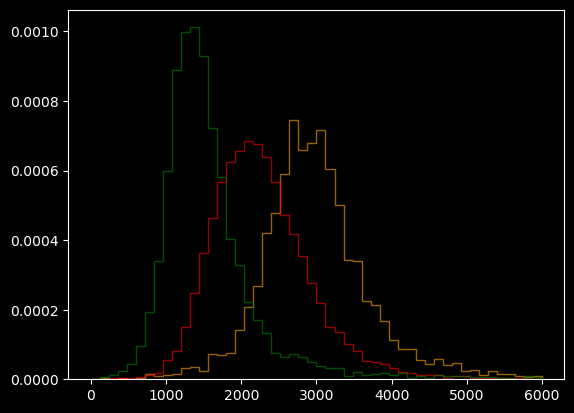

In [72]:
plt.hist(SC_0411.volumes[1:], color=['g','r','orange'], alpha=0.6, bins=50, range=(0,6000), density=True, histtype='step')
plt.show()

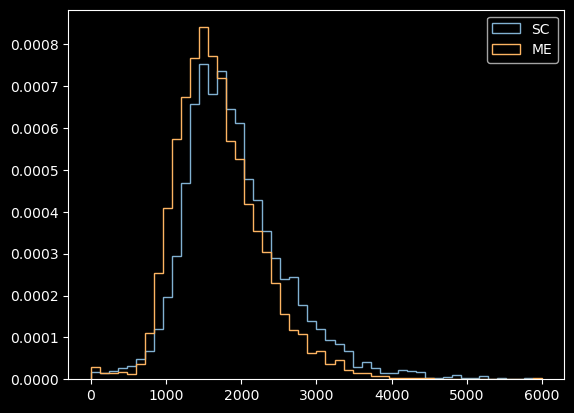

In [68]:
# plot G1 volumes for ME and SC as histograms
plt.hist(SC.volumes[1], bins=50, range=(0,6000), density=True, histtype='step', label='SC', color='C4')
plt.hist(ME.volumes[1], bins=50, range=(0,6000), density=True, histtype='step', label='ME', color='C5')

plt.legend()